# Objetivo del Proyecto "Soy (soja) Seasonality - Time Series Practice"

El objetivo de este proyecto es practicar y determinar la estacionalidad de la producción de soja mediante el análisis de series temporales. Utilizaré algunas técnicas aprendidas en el curso de series temporales (estacionalidad) para desglosar y modelar los datos, buscando identificar patrones estacionales que permitan predecir las tendencias de producción de soja de manera precisa. Posteriormente aplicaremos modelos de ML hibridos para la prediccion del valor de la soja.

### Metodologia comun a seguir: 

Preparación de Datos: Se reorganizan los datos y se selecciona el año.

Características Deterministas: Se crean características estacionales y cíclicas usando Fourier y un proceso determinista.

Entrenamiento: Se entrena un modelo de regresión lineal con las características generadas.

Predicción y Visualización: Se realizan predicciones y se visualizan.


In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 43.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293631 sha256=4df4ba10da7f5843f274db3dd8fc15ece09cb9f7282cf425b1c52c9a7ed4decc
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [2]:
# de ahora en mas cada vez que vea celda util pondre un "*" para poder marcarla y guadarla para las siguientes
# como en este "setup de visualziaciones" tras guardarlo se borra y listo
#*

# Setup de visualizaciones


from pathlib import Path
from warnings import simplefilter

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor



# simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

/tmp/ipykernel_33/679524068.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
#*
# Funciones de graficacion para determinar estacionalidad
# Funciones de graficación para determinar estacionalidad

# Esta función genera un gráfico estacional
def seasonal_plot(X, y, period, freq, ax=None):
    # Si no se proporciona un objeto 'ax', crea uno nuevo
    if ax is None:
        _, ax = plt.subplots()
    # Selecciona una paleta de colores para diferenciar los periodos
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    # Crea un gráfico de líneas para visualizar la estacionalidad
    ax = sns.lineplot(
        x=freq,                # Eje x con la frecuencia temporal
        y=y,                   # Eje y con los valores a graficar
        hue=period,            # Diferencia las líneas por el periodo
        data=X,                # DataFrame que contiene los datos
        ci=False,              # No mostrar intervalos de confianza
        ax=ax,                 # Eje sobre el que se graficará
        palette=palette,       # Paleta de colores para las líneas
        legend=False,          # No mostrar la leyenda
    )
    # Establece el título del gráfico
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    # Anota el último valor de cada línea con el nombre del periodo
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]  # Obtiene el último valor y
        ax.annotate(
            name,                      # Texto de la anotación
            xy=(1, y_),                # Coordenadas de la anotación
            xytext=(6, 0),             # Desplazamiento del texto
            color=line.get_color(),    # Color del texto
            xycoords=ax.get_yaxis_transform(), # Coordenadas del eje y
            textcoords="offset points", # Coordenadas del texto
            size=14,                   # Tamaño de la fuente
            va="center",               # Alineación vertical del texto
        )
    return ax  # Devuelve el objeto 'ax' para posibles modificaciones adicionales


# Esta función genera un periodograma para analizar la periodicidad
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    # Define la frecuencia de muestreo en términos de días
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    # Calcula el periodograma usando la función periodogram
    freqencies, spectrum = periodogram(
        ts,                     # Serie temporal a analizar
        fs=fs,                  # Frecuencia de muestreo
        detrend=detrend,        # Método de detrendizado
        window="boxcar",        # Ventana utilizada para el cálculo
        scaling='spectrum',     # Escalado del espectro
    )
    # Si no se proporciona un objeto 'ax', crea uno nuevo
    if ax is None:
        _, ax = plt.subplots()
    # Crea un gráfico de pasos para el periodograma
    ax.step(freqencies, spectrum, color="purple")
    # Configura el eje x para que esté en escala logarítmica
    ax.set_xscale("log")
    # Establece los ticks y etiquetas del eje x
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",           # Anual
            "Semiannual (2)",       # Semi-anual
            "Quarterly (4)",        # Trimestral
            "Bimonthly (6)",        # Bimensual
            "Monthly (12)",         # Mensual
            "Biweekly (26)",        # Quincenal
            "Weekly (52)",          # Semanal
            "Semiweekly (104)",     # Semi-semanal
        ],
        rotation=30,              # Rotación de las etiquetas
    )
    # Configura el formato de las etiquetas del eje y en notación científica
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    # Establece la etiqueta del eje y
    ax.set_ylabel("Variance")
    # Establece el título del gráfico
    ax.set_title("Periodogram")
    return ax  # Devuelve el objeto 'ax' para posibles modificaciones adicionales


In [4]:
# Descargar datos de la soja (ejemplo con contrato futuro de la soja)
soybeans = yf.download('ZC=F', start='2001-01-01', end='2024-01-01')  # Contrato futuro de soja en NYMEX
data = soybeans
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,221.00,221.00,221.0,222.50,222.50,1466
2001-01-16,219.00,219.00,217.5,218.50,218.50,957
2001-01-17,216.00,217.00,215.5,216.25,216.25,519
2001-01-18,217.50,219.00,217.5,218.75,218.75,940
2001-01-19,218.25,219.50,218.0,218.50,218.50,519
...,...,...,...,...,...,...
2023-12-22,472.50,474.00,471.5,473.00,473.00,80484
2023-12-26,473.00,481.00,471.5,480.25,480.25,114198
2023-12-27,479.75,480.25,474.5,476.50,476.50,107950


              Open   High    Low   Close  Adj Close  Volume
Date                                                       
2001-01-02  221.00  221.0  221.0  222.50     222.50    1466
2001-01-16  219.00  219.0  217.5  218.50     218.50     957
2001-01-17  216.00  217.0  215.5  216.25     216.25     519
2001-01-18  217.50  219.0  217.5  218.75     218.75     940
2001-01-19  218.25  219.5  218.0  218.50     218.50     519


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Soy / ZC=F')

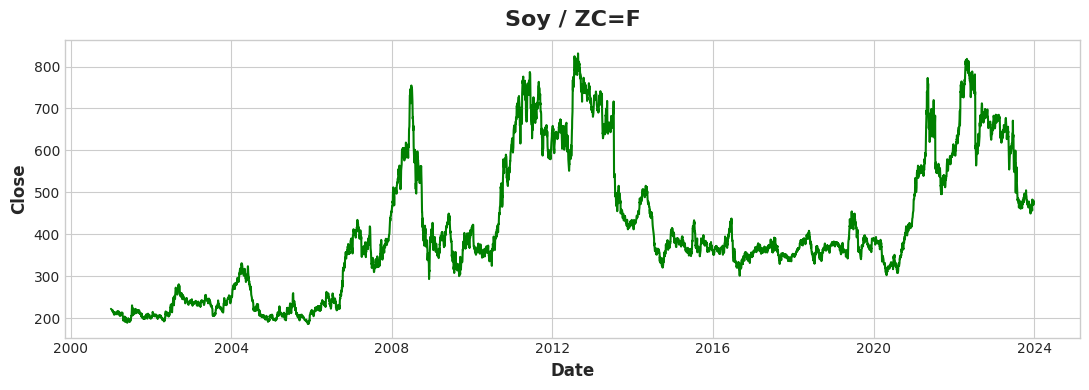

In [5]:
# vemos tipo de df
type(data) # es de tipo pandas.core.frame.DataFrame

print(data.head())
sns.lineplot(x = data.index, y = data.Close, color = 'green')
plt.title('Soy / ZC=F')

In [6]:
data.index

DatetimeIndex(['2001-01-02', '2001-01-16', '2001-01-17', '2001-01-18',
               '2001-01-19', '2001-01-22', '2001-01-23', '2001-01-24',
               '2001-01-25', '2001-01-26',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=5769, freq=None)

# Seasonal Plot

[*********************100%%**********************]  1 of 1 completed


              Open    High     Low   Close  Adj Close  Volume  month  \
Date                                                                   
2010-01-04  415.75  426.25  413.25  418.50     418.50  140553      1   
2010-01-05  417.25  420.00  415.25  418.75     418.75   80967      1   
2010-01-06  418.00  422.00  416.00  421.75     421.75   96453      1   
2010-01-07  421.00  424.00  414.50  417.50     417.50  137395      1   
2010-01-08  417.50  423.75  415.00  423.00     423.00  137395      1   

            day_of_year  year  
Date                           
2010-01-04            4  2010  
2010-01-05            5  2010  
2010-01-06            6  2010  
2010-01-07            7  2010  
2010-01-08            8  2010  


<Axes: title={'center': 'Seasonal Plot (year/month)'}, xlabel='month', ylabel='Close'>

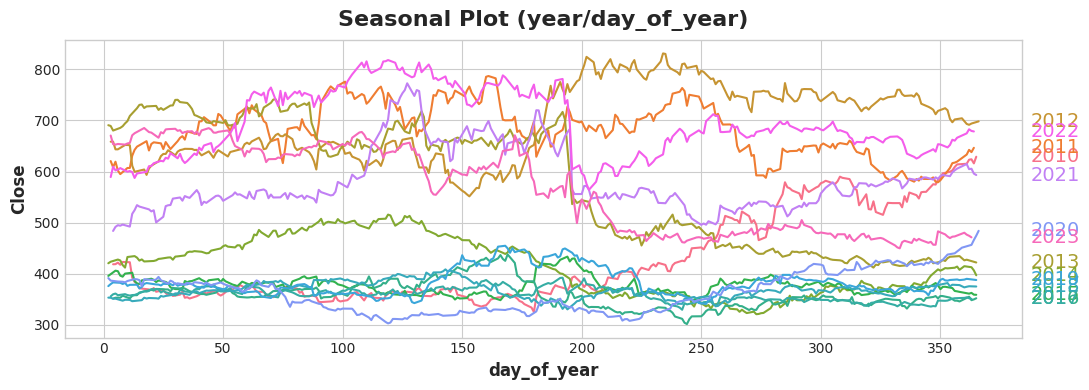

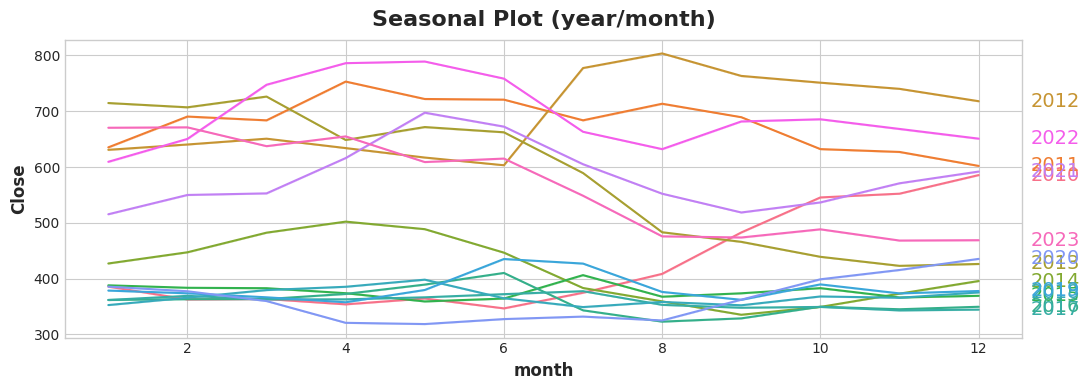

In [7]:
import warnings
import pandas as pd
import yfinance as yf

# Ignorar advertencias
warnings.filterwarnings('ignore')

# Descargar datos desde 2001
soybeans = yf.download('ZC=F', start='2001-01-01', end='2024-01-01')

# Crear características basadas en el índice temporal
X = soybeans.copy()
X['month'] = X.index.month
X['day_of_year'] = X.index.dayofyear
X['year'] = X.index.year

# Filtrar datos a partir de 2010
X_2010 = X.loc['2010':]

# Mostrar las primeras filas del DataFrame filtrado
print(X_2010.head())

# Asegúrate de que tienes definida la función seasonal_plot
# Graficar estacionalidad con los datos desde 2010
seasonal_plot(X_2010, y='Close', period='year', freq='day_of_year')
seasonal_plot(X_2010, y='Close', period='year', freq='month')


# Mean Close Price per month (all years)

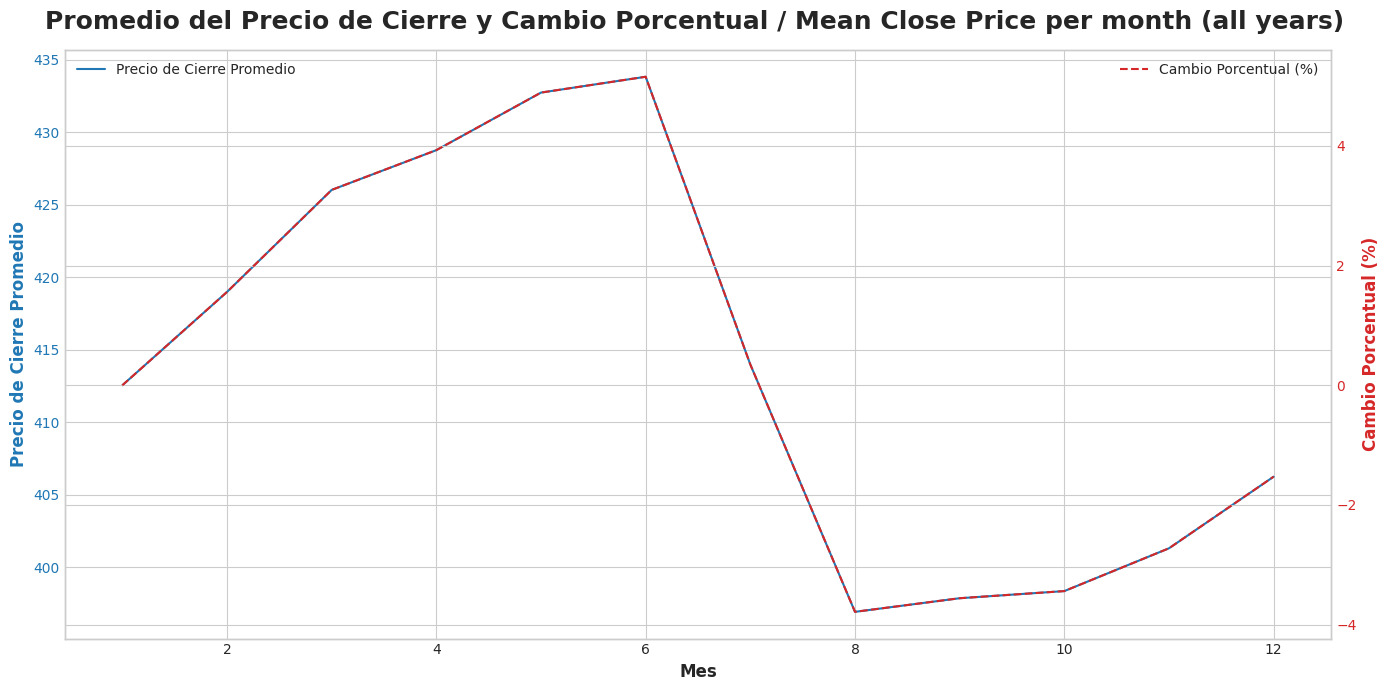

In [8]:
y_allY_mean =X.groupby('month').Close.mean()
y_allY_mean
# y_allY_mean.plot()

# Calcular los porcentajes en relación con el punto de referencia
reference_value = y_allY_mean.iloc[0]
percentage_changes = ((y_allY_mean - reference_value) / reference_value) * 100

# Mostrar los resultados
# print(percentage_changes)
# percentage_changes.plot()

# print(y_allY_mean)
# def plot_change(y_allY_mean)
# Crear la figura y el primer eje Y
fig, ax1 = plt.subplots(figsize=(14, 7))

# Graficar el promedio del precio de cierre usando seaborn
sns.lineplot(x=y_allY_mean.index, y=y_allY_mean, ax=ax1, color='tab:blue', label='Precio de Cierre Promedio')

# Configurar el primer eje Y
ax1.set_xlabel('Mes')
ax1.set_ylabel('Precio de Cierre Promedio', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Crear un segundo eje Y para los porcentajes
ax2 = ax1.twinx()  # Crea un nuevo eje Y que comparte el eje X con ax1
sns.lineplot(x=percentage_changes.index, y=percentage_changes, ax=ax2, color='tab:red', linestyle='--', label='Cambio Porcentual (%)')

# Configurar el segundo eje Y
ax2.set_ylabel('Cambio Porcentual (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Títulos y leyendas
fig.suptitle('Promedio del Precio de Cierre y Cambio Porcentual / Mean Close Price per month (all years)')
ax1.legend(loc='upper left')


# Mean Close Price per day_of_year (all years)

max_y_allY_mean :  732.375
Claves asociadas al valor (day): [185]


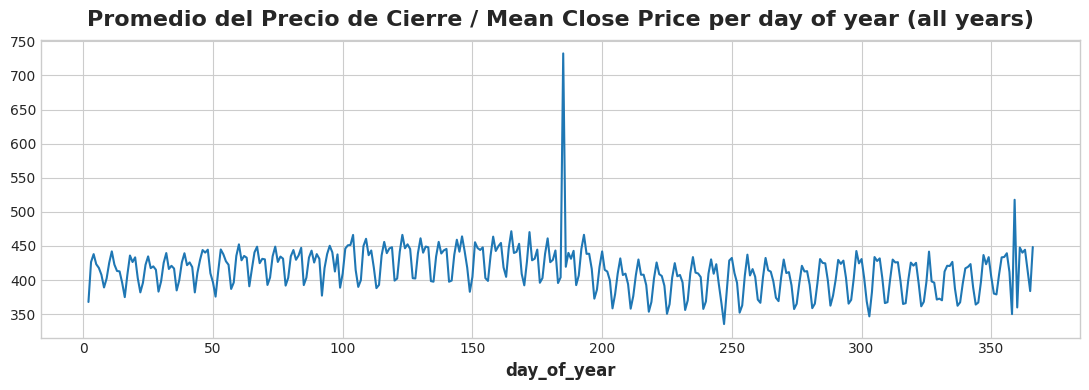

In [9]:
y_allY_mean =X.groupby('day_of_year').Close.mean()
y_allY_mean.plot()

max_y_allY_mean = y_allY_mean.max()
print("max_y_allY_mean : ", max_y_allY_mean)
dict_mm = dict(y_allY_mean)
maxxt = max(dict_mm) 

# Encuentra las claves correspondientes al valor buscado
claves = [clave for clave, valor in dict_mm.items() if valor == max_y_allY_mean]
plt.title('Promedio del Precio de Cierre / Mean Close Price per day of year (all years)')

print("Claves asociadas al valor (day):", claves)

In [10]:
y_allY_mean.info()

<class 'pandas.core.series.Series'>
Index: 365 entries, 2 to 366
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
365 non-null    float64
dtypes: float64(1)
memory usage: 10.4 KB


**Conclusión:**

La tendencia estacional observada en el precio de cierre de la soja, con un aumento **promedio** del 4% desde enero hasta junio seguido de una disminución hasta diciembre, puede ser atribuida a una combinación de factores agrícolas, económicos y climáticos. La estacionalidad en los precios de commodities refleja la interacción entre la oferta y la demanda, el ciclo de cultivo, las expectativas de los mercados y los riesgos asociados con la producción. Comprender estas dinámicas es crucial para la toma de decisiones en el sector agrícola y para los inversores en los mercados de commodities.

**Observación:**
En el análisis de los precios de cierre de la soja desde el año 2000 hasta la actualidad, se ha observado una tendencia estacional en la que el precio tiende a aumentar desde enero hasta junio en un 4% en promedio, y luego disminuye hasta diciembre.


**Explicación:**

1. **Estacionalidad en los Mercados de Commodities:**
   La estacionalidad en los precios de commodities, como la soja, a menudo se debe a una combinación de factores agrícolas, económicos y de mercado. En el caso de la soja, los patrones estacionales pueden ser influenciados por:

   - **Ciclo de Cultivo:** La soja es un cultivo que sigue un ciclo anual. En el hemisferio norte, la siembra suele comenzar en primavera (alrededor de abril o mayo) y la cosecha en otoño (septiembre a noviembre). El aumento en los precios desde enero hasta junio puede estar asociado con la anticipación de la siembra, el aumento de la demanda de semillas y fertilizantes, y la reducción de la oferta debido al uso de reservas de inventario.

   - **Demanda y Oferta:** A medida que se acerca la época de siembra, los agricultores y los productores ajustan sus planes basados en expectativas de precios y condiciones climáticas. Un aumento en la demanda de insumos y la especulación en el mercado pueden impulsar los precios. Luego, una vez que la cosecha se aproxima y la oferta aumenta, los precios pueden disminuir.

2. **Efectos Climáticos y Agrícolas:**
   - **Condiciones Climáticas:** El precio de los productos agrícolas está influenciado por las condiciones climáticas que afectan la producción. Durante los meses de crecimiento, la incertidumbre sobre el clima puede llevar a precios más altos debido a la especulación sobre la calidad de la cosecha. Una vez que el clima y la cosecha son más predecibles, los precios pueden estabilizarse o disminuir.

   - **Riesgos de Producción:** En los primeros meses del año, los riesgos relacionados con la producción y el crecimiento de los cultivos son inciertos, lo que puede llevar a precios más altos debido a la incertidumbre. A medida que la temporada avanza y se clarifican las expectativas sobre el rendimiento de la cosecha, los precios pueden ajustar hacia abajo.

3. **Factores Económicos y de Mercado:**
   - **Políticas de Inventario y Almacenamiento:** Las políticas de almacenamiento de inventario también juegan un papel importante. Los productores y comerciantes pueden acumular inventario cuando los precios son bajos y vender cuando los precios son altos, lo que contribuye a las fluctuaciones estacionales.

   - **Impacto de los Mercados Internacionales:** Los precios de los commodities también están influidos por el comercio internacional y los cambios en las políticas comerciales. Por ejemplo, la demanda de soja en mercados internacionales puede afectar los precios, y las políticas comerciales o cambios en los acuerdos internacionales pueden impactar en la oferta y demanda global.


# Periodograma

In [11]:
data.Close

Date
2001-01-02    222.50
2001-01-16    218.50
2001-01-17    216.25
2001-01-18    218.75
2001-01-19    218.50
               ...  
2023-12-22    473.00
2023-12-26    480.25
2023-12-27    476.50
2023-12-28    474.25
2023-12-29    471.25
Name: Close, Length: 5769, dtype: float64

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

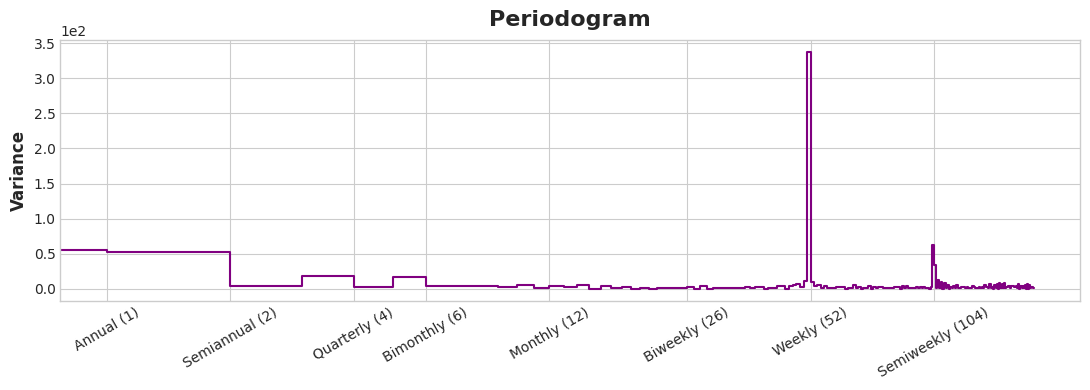

In [12]:
y_allY_mean = X.groupby('day_of_year').Close.mean()
plot_periodogram(y_allY_mean)

El periodograma sugiere una fuerte estacionalidad semanal. 

El periodograma muestra la variabilidad del promedio del precio de cierre de los días del año en función de diferentes frecuencias. La frecuencia semanal (52) tiene el pico más alto, lo que indica que la mayor variabilidad se produce en una escala semanal. Esto sugiere que hay una estacionalidad significativa con una periodicidad de una semana en los datos de precios de cierre.

Esto puede significar que los precios de cierre tienden a seguir un patrón que se repite semanalmente. Otras frecuencias con picos más pequeños indican patrones de variabilidad menores en esas escalas temporales.

# CalendarFourier and DeterministicProcess

Utilizando el análisis de estacionalidad que observe en el periodograma, puedo ajustar el proceso determinista (DeterministicProcess) y las características de Fourier para capturar mejor los patrones semanales observados. Dado que el periodograma muestra una fuerte estacionalidad semanal:

---

### Captura de Patrones Estacionales con `CalendarFourier` y `DeterministicProcess`

Para analizar y capturar patrones estacionales en series temporales, usamos dos herramientas poderosas: `CalendarFourier` y `DeterministicProcess`.

**1. CalendarFourier:**
- **¿Qué es?** Es una técnica que utiliza la transformada de Fourier para modelar componentes estacionales en datos. Específicamente, descompone las series temporales en términos de ondas senoidales y cosenoidales para capturar patrones que se repiten a lo largo del tiempo.
- **¿Por qué es útil?** Permite identificar y modelar efectos estacionales con diferentes frecuencias, como estaciones del año o ciclos anuales, proporcionando una forma flexible y eficiente de capturar la estacionalidad.

**2. DeterministicProcess:**
- **¿Qué es?** Es un marco que utiliza funciones determinísticas (como las ondas de Fourier) para construir un modelo de serie temporal. Incluye opciones para añadir términos de tendencia, estacionalidad y otros componentes.
- **¿Por qué es útil?** Facilita la integración de términos estacionales y tendencias en el modelo, permitiendo una representación precisa de los patrones en los datos. Es ideal para ajustar y predecir series temporales que presentan estacionalidades complejas.

**En resumen:**
- **`CalendarFourier`** modela la estacionalidad mediante términos Fourier.
- **`DeterministicProcess`** combina estos términos con otros componentes para construir un modelo robusto de la serie temporal.

Utilizando ambos, podemos capturar patrones estacionales con mayor precisión, lo que resulta en mejores modelos predictivos y un entendimiento más profundo de los datos.

---


**Problemas experimentados y solucionados en el camino**: 
- necesitamos si o si tener un formato fecha y los "day of weeks" tiene que estar en columnas apartes por lo que en mi caso use una fecha auxiliar de un año (2020).

- no tiene que haber NaN values por lo que tambien en mi caso lo rellene con fillna(mean)

## crear terminos de fourier

In [13]:
# Crear DataFrame a partir del Series
df = y_allY_mean.reset_index()
df.columns = ['day_of_year', 'Close']

# Crear un índice de fechas para representar los días del año
date_rng = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D') # REQUERIDO Y USADO SOLO PARA PODER "CORRER" EL ALGORITMO DE "Deterministic process"
df_date = pd.DataFrame(date_rng, columns=['date'])
df_date['day_of_year'] = df_date['date'].dt.dayofyear

# Unir los datos con los valores promedio
df = pd.merge(df_date, df, on='day_of_year', how='left')

# Rellenar los valores faltantes
df['Close'] = df['Close'].fillna(method='ffill')

# Establecer el índice de fecha
df.set_index('date', inplace=True)
mean = df['Close'].mean()
df = df.fillna(mean) # rellenamos valores NaN con el promedio, a fin de evitar problemas al compilar la celda
df

,day_of_year,Close
date,,
2020-01-01,1,414.778794
2020-01-02,2,367.875000
2020-01-03,3,426.421875
2020-01-04,4,438.046875
2020-01-05,5,423.283333
...,...,...
2020-12-27,362,440.218750
2020-12-28,363,444.437500
2020-12-29,364,414.562500


In [14]:
# Crear términos Fourier
fourier = CalendarFourier(freq='W', order=4)  # freq = 'W' para semanal, dada su importancia vista en el periodograma   # otros parametros son freq = 'A' para anual, order es el número de términos Fourier

# Crear el proceso determinístico
dp = DeterministicProcess(
    index=df.index,
    constant=True,               # Incluye un intercepto (beta_0)
    order=1,                     # Incluye una tendencia lineal (beta_1 * t)
    seasonal=False,              # No incluye términos de estacionalidad específicos
    additional_terms=[fourier],  # Añade términos Fourier
    drop=True                    # Elimina duplicados (si hay)
)

# Generar los términos determinísticos
X = dp.in_sample()


In [15]:
# Asignar valores a y sin usar inplace=True
y = df['Close']

# Ajustar el modelo
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)


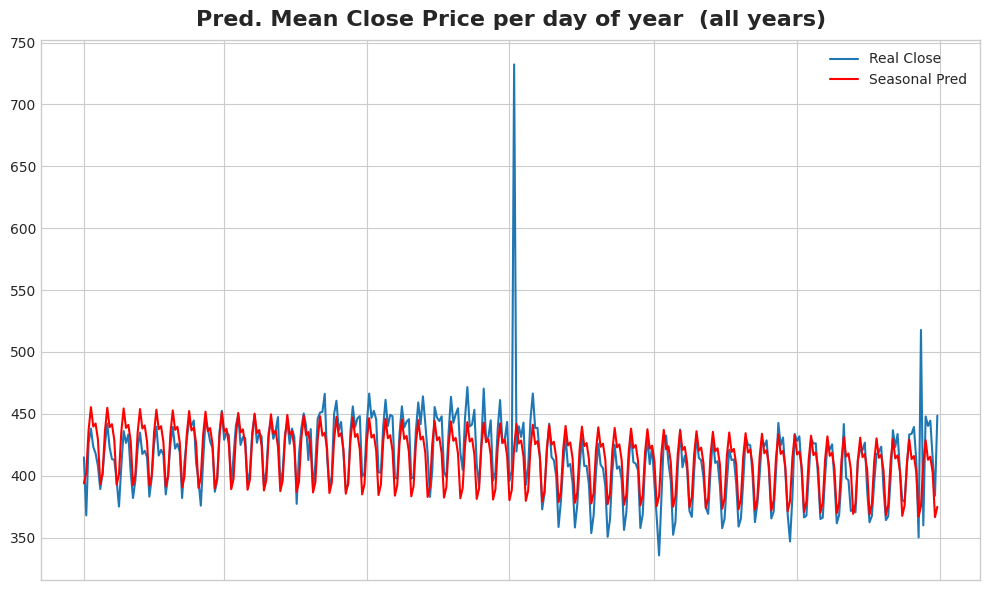

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Real Close')
plt.plot(df.index, y_pred, label='Seasonal Pred', color='red')
plt.legend()
plt.title('Pred. Mean Close Price per day of year  (all years)')

# Ocultar las etiquetas del eje X, pero mantener el eje
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())

plt.show()


# Prediccion de valor de cierre.

### Uso de Modelos Híbridos en Predicción de Series Temporales

En la predicción de series temporales, combinar modelos como la **Regresión Lineal** y el **XGBoostRegressor** puede ofrecer ventajas significativas. Aquí te explicamos por qué y cómo funciona:

**1. Regresión Lineal:**
- **¿Qué es?** Un modelo simple que estima la relación entre variables mediante una línea recta. En series temporales, puede capturar tendencias y efectos estacionales básicos.
- **¿Por qué usarlo?** Es rápido y fácil de interpretar. Funciona bien cuando las relaciones entre las variables son lineales y los datos son relativamente simples.

**2. XGBoostRegressor:**
- **¿Qué es?** Un modelo de boosting basado en árboles de decisión, conocido por su rendimiento y precisión en tareas de regresión. Maneja bien interacciones complejas y no lineales entre variables.
- **¿Por qué usarlo?** Es eficaz para capturar patrones complejos y no lineales en los datos. Ofrece una mayor capacidad predictiva en comparación con modelos más simples.

**Modelos Híbridos:**
- **¿Qué son?** La combinación de modelos lineales y avanzados como XGBoostRegressor. Por ejemplo, puedes usar la regresión lineal para capturar componentes simples pero robustos, y XGBoost para modelar patrones mas complejos.
- **¿Por qué aplicarlos?** Un enfoque híbrido aprovecha las fortalezas de cada modelo. La regresión lineal proporciona una base sólida, mientras que XGBoost mejora la precisión al capturar detalles más complejos. Esto resulta en un modelo más robusto y preciso.

**En resumen:**
- **Regresión Lineal** captura tendencias y patrones básicos.
- **XGBoostRegressor** maneja complejidades y no linealidades.
- **Modelos Híbridos** combinan ambos para mejorar la precisión y robustez en la predicción de series temporales.

Usar modelos híbridos permite obtener lo mejor de ambos mundos, logrando mejores predicciones y una mayor comprensión de los datos temporales.

---


## Definimos **clase** estilo scikit learn para poder crear modelos hibridos y predecir valores

In [43]:
# Ajuste del método fit de la clase BoostedHybrid
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2

    def fit(self, X_1, X_2, y):
        # Ajusta el primer modelo (model_1) usando los datos de entrada X_1 y las etiquetas y.
        self.model_1.fit(X_1, y)

        # Realiza predicciones con el primer modelo (model_1) sobre los datos X_1.
        y_fit = pd.Series(
            self.model_1.predict(X_1),  # Predicciones del modelo 1
            index=X_1.index  # Mantiene el índice de X_1
        )

        # Calcula los residuos como la diferencia entre las etiquetas reales y las predicciones.
        y_resid = y - y_fit
        
        # Ajusta el segundo modelo (model_2) usando X_2 y los residuos calculados.
        self.model_2.fit(X_2, y_resid)

    def predict(self, X_1, X_2):
        # Predice con el primer modelo
        y_pred = pd.Series(
            self.model_1.predict(X_1),
            index=X_1.index
        )

        # Suma las predicciones del segundo modelo (ajustado sobre los residuos)
        y_pred += self.model_2.predict(X_2)

        return y_pred


In [48]:
X = soybeans.copy()
X2 = X.drop('Close', axis=1)  # axis=1 para eliminar la columna 'Close'

# Target series
y = X.loc[:, 'Close']

In [46]:
y

Date
2001-01-02    222.50
2001-01-16    218.50
2001-01-17    216.25
2001-01-18    218.75
2001-01-19    218.50
               ...  
2023-12-22    473.00
2023-12-26    480.25
2023-12-27    476.50
2023-12-28    474.25
2023-12-29    471.25
Name: Close, Length: 5769, dtype: float64

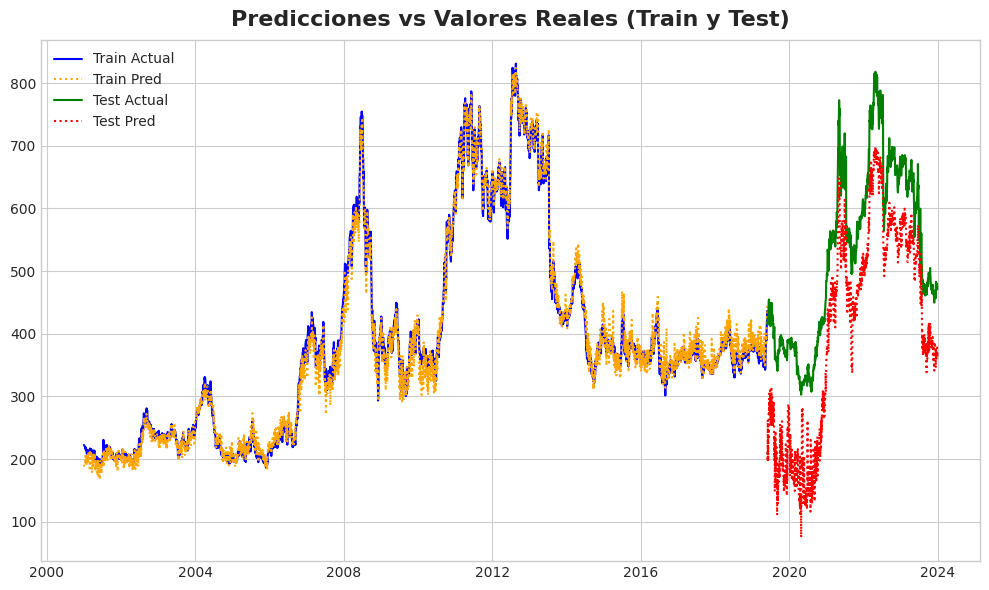

In [52]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, shuffle=False)

# Crear las matrices correspondientes para X_1
dp_train = DeterministicProcess(index=y_train.index, order=1)
X_1_train = dp_train.in_sample()

dp_test = DeterministicProcess(index=y_test.index, order=1)
X_1_test = dp_test.in_sample()

# Crear el modelo híbrido
model = BoostedHybrid(LinearRegression(), XGBRegressor())

# Ajustar el modelo con los datos de entrenamiento
model.fit(X_1_train, X_train, y_train)

# Hacer predicciones para los conjuntos de entrenamiento y prueba
y_pred_train = model.predict(X_1_train, X_train)
y_pred_test = model.predict(X_1_test, X_test)

# Clip para evitar valores negativos en las predicciones
y_pred_train = y_pred_train.clip(0.0)
y_pred_test = y_pred_test.clip(0.0)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train Actual', color='blue')
plt.plot(y_train.index, y_pred_train, label='Train Pred', color='orange', linestyle = 'dotted')
plt.plot(y_test.index, y_test, label='Test Actual', color='green')
plt.plot(y_test.index, y_pred_test, label='Test Pred', color='red', linestyle = 'dotted')
plt.legend()
plt.title('Predicciones vs Valores Reales (Train y Test)')
plt.show()


In [54]:
from sklearn.metrics import mean_squared_error

# Luego puedes usar la función como lo hacías antes:
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"Train RMSE: {train_rmse:.2f}\nTest RMSE: {test_rmse:.2f}")

# Bastante alto el test RMSE, hay que seguir investigando, y ver como mejorar la prediccion del modelo
# Tarea que lo dejo para luego.

Train RMSE: 13.53
Test RMSE: 131.11


# Conclusión de lo Aprendido hasta Acá

En el análisis de series temporales, los algoritmos de aprendizaje automático utilizados son similares a los aplicados en el aprendizaje supervisado tradicional, pero con algunas consideraciones clave:

1. **Importancia del Orden Temporal**: A diferencia del aprendizaje supervisado en datos estáticos, en las series temporales el orden de los datos es crucial. La temporalidad implica que los valores de la serie están correlacionados a lo largo del tiempo, por lo que el modelo debe respetar esta estructura para hacer predicciones precisas.

2. **Modelos Híbridos**: Hemos aprendido a combinar modelos lineales, como la regresión lineal, con algoritmos más avanzados como XGBoost para capturar tanto las tendencias lineales como las no lineales en los datos. Este enfoque híbrido permite aprovechar lo mejor de ambos mundos, mejorando la capacidad del modelo para generalizar.

3. **Estacionalidad y Tendencias**: Identificar y modelar patrones estacionales es fundamental en series temporales. Herramientas como `DeterministicProcess` y `CalendarFourier` nos permiten capturar estas características de manera eficiente, mejorando la precisión de nuestras predicciones.

4. **Evaluación de Modelos**: La evaluación de modelos en series temporales debe hacerse con cuidado para evitar el "look-ahead bias". Esto implica dividir los datos en conjuntos de entrenamiento y prueba que respeten la secuencia temporal, evaluando el rendimiento en datos que el modelo no ha visto.

En resumen, aunque los algoritmos de aprendizaje automático que se aplican en series temporales pueden ser similares a los del aprendizaje supervisado, la naturaleza secuencial y dependiente del tiempo de los datos requiere un enfoque adaptado para capturar correctamente las dinámicas temporales.